In [1]:
import sys, copy, os
import numpy as np

from LGR.lgr import *
from LGR.jacobian import *
from LGR.classes import *
from LGR.plotting import *
from Flows.Flows import *

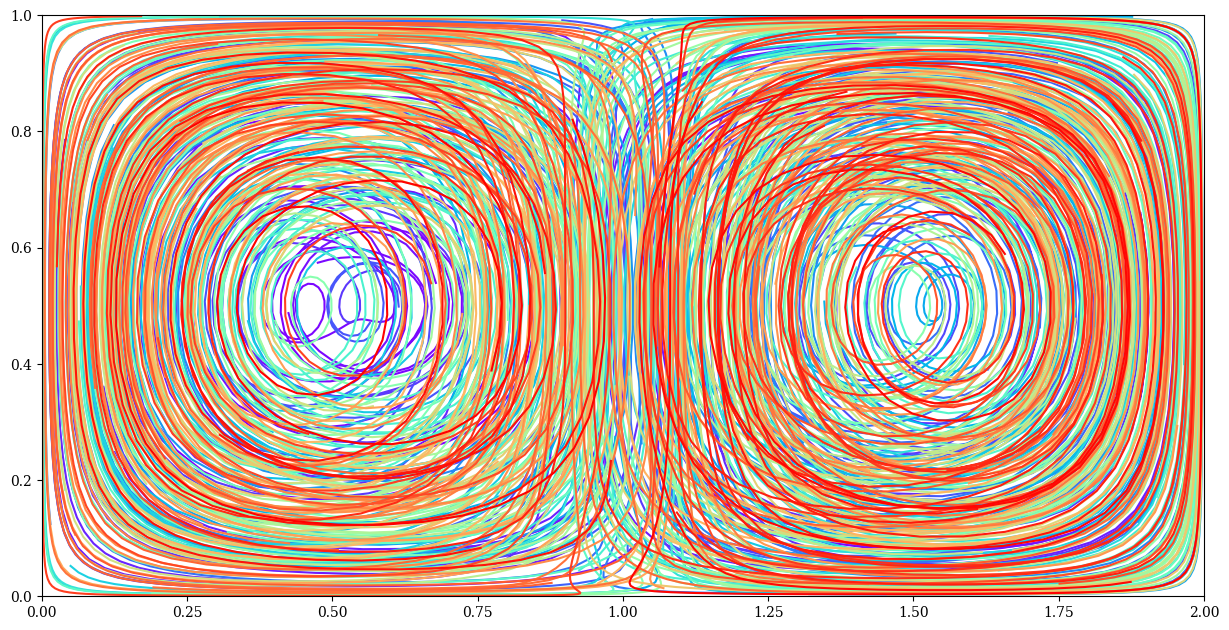

In [2]:
# Generate random trajectory data for the double gyre flow

# basic parameters:
flowname = "Gyre"
n_particles = 200
n_steps = 100
dt = 0.25    

# optional parameters
parameters = {  # These are specified as defaults as well. 
    "A": 0.1,
    "epsilon": 0.1,
    "omega":2*np.pi/10
}

# Initialize the flow 
flow = Flow()

# Generate random initial conditions on domain [[0,2],[0,1]] -> [x, y]
ICs = np.random.rand(n_particles,2)
ICs[:,0] *= 2

# Generate a time vector
tvec = np.linspace(0, dt*n_steps, n_steps) 

# Generate the trajectories
flow.predefined_function(flowname, ICs, tvec, parameters=parameters)
flow.integrate_trajectories()
trajectories = flow.states

# Generate a list of particles
particleList = []
for i in range(n_particles):
    state = np.squeeze(trajectories[i,:,:])
    particleList.append(SimpleParticle(state, tvec, i))
    
# plot the trajectories
plot_trajectories(trajectories)

In [3]:
# Set computational parameters
t = 15              # time duration for LCS analysis
kNN = 50             # Number of nearest neighbors to find for each particle
reg_type = 'radialGaussian'   # 'None' or 'radialGaussian'
sigma = 0.15       # standard deviation if reg_type is radial_gaussian
lam = 0.000000001   # Regularizer for the regression 
nx = 150            # grid length in x for interpolation (plotting)

# Generate the regression function
regfun = setRegressionFunction(kernel=reg_type, lam=lam, sig=sigma)

# specify which metrics to compute
metrics = ["ftle", "lavd", "dra", "vort"]


In [4]:
# Generate a data frame
df = generateDF(particleList, kNN)
n_particles = len(df['indices'][0])

KNN: t = 0.0
KNN: t = 6.313131313131313
KNN: t = 12.626262626262626
KNN: t = 18.93939393939394


In [5]:
# Perform the regressions
calcJacobianAndVelGrad(df, regfun=regfun)

Regression: t = 0.0
Regression: t = 6.313131313131313
Regression: t = 12.626262626262626
Regression: t = 18.93939393939394


In [6]:
# Compute the metrics on each particle trajectory
computeMetrics(df, t, metric_list=metrics)

Metrics: t = 0.0
Metrics: t = 6.313131313131313
Metrics: t = 12.626262626262626
Metrics: t = 18.93939393939394


In [7]:
# Interpolate the metrics onto a grid assuming the double gyre flow.
xvec = np.linspace(0,2,nx)
yvec = np.linspace(0,1,int(nx/2))   # square cells on the double gyre flow
gridvectors = [xvec, yvec]
if n_particles < 1000:
    generateFields(df, gridvectors, approach='rbf', method='multiquadric')
    interpstr = 'rbf_mq'
else:
    generateFields(df, gridvectors, approach='interp', method='cubic')
    interpstr = 'int3'

Interpolation: t = 0.0
Interpolation: t = 6.313131313131313
Interpolation: t = 12.626262626262626
Interpolation: t = 18.93939393939394


d:\OneDrive\Research\PhD\Publications\Journal Articles\2023\LCS Computation Paper\Code\LGR\plotting.py:176: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


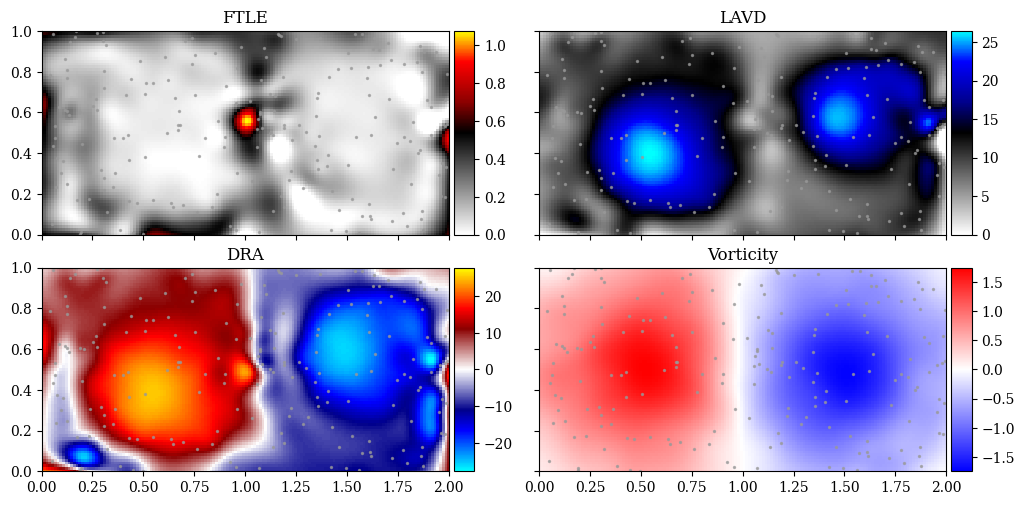

In [8]:
# plot the results
plotAllMetrics(df, xvec, yvec, tstep=0)